Paper Reference : https://j-innovative.org/index.php/Innovative/article/download/15199/10372/26113

In [ ]:
import os
from modules.SignLanguageProcessor import load_and_preprocess_data,parse_frame

In [ ]:
ROOT_PATH = ''
sequences,labels,label_map = load_and_preprocess_data(os.path.join(ROOT_PATH,'data'))

In [16]:
num_classes = len(label_map)

In [17]:
len(labels)

3413

In [18]:
sequences.shape

(3413, 3, 61, 3)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    sequences, labels, test_size=0.4, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [20]:
import numpy as np
def normalize_landmark_data(X):
    """
    Normalize the landmark features (x, y) to have zero mean and unit variance across the training set.
    Assumes X shape is (N, F, L, T), where F=3 (x, y, vis).
    """
    X = X.copy()
    # Flatten across all samples, landmarks, and frames
    x_vals = X[:, 0, :, :].flatten()
    y_vals = X[:, 1, :, :].flatten()

    # Compute mean and std
    x_mean, x_std = np.mean(x_vals), np.std(x_vals)
    y_mean, y_std = np.mean(y_vals), np.std(y_vals)

    # Normalize
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std

    return X, (x_mean, x_std), (y_mean, y_std)

def apply_normalization(X, x_mean, x_std, y_mean, y_std):
    X = X.copy()
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std
    return X


In [21]:
def reshape_frames_for_cnn(X, y):
    """
    Reshape a dataset of (N, F, L, T) into (N*T, L, F, 1) for Conv2D,
    where each frame becomes its own sample.

    Parameters:
    - X: np.ndarray of shape (N, F, L, T)
    - y: np.ndarray of shape (N,)

    Returns:
    - reshaped_X: np.ndarray of shape (N*T, L, F, 1)
    - reshaped_y: np.ndarray of shape (N*T,)
    """
    reshaped_X = []
    reshaped_y = []

    for sample, label in zip(X, y):
        T = sample.shape[-1]
        for t in range(T):
            frame = sample[:, :, t].T[..., np.newaxis] 
            reshaped_X.append(frame)
            reshaped_y.append(label)

    reshaped_X = np.array(reshaped_X)
    reshaped_y = np.array(reshaped_y)
    return reshaped_X, reshaped_y

In [22]:

X_train_norm, (x_mean, x_std), (y_mean, y_std) = normalize_landmark_data(X_train)
X_val_norm  = apply_normalization(X_val, x_mean, x_std, y_mean, y_std)
X_test_norm = apply_normalization(X_test, x_mean, x_std, y_mean, y_std)

X_train_cnn, y_train_cnn = reshape_frames_for_cnn(X_train_norm, y_train)
X_val_cnn, y_val_cnn     = reshape_frames_for_cnn(X_val_norm, y_val)
X_test_cnn, y_test_cnn   = reshape_frames_for_cnn(X_test_norm, y_test)

print(X_train_cnn.shape)  
print(y_train_cnn.shape)


(6141, 61, 3, 1)
(6141,)


In [23]:
input_shape = X_train_cnn.shape[1:]
print(input_shape)

(61, 3, 1)


In [24]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_cnn))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_cnn))
test_ds = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,Input

cnn_model = Sequential([
    Input(input_shape),
    Conv2D(32, (3, 2), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    Dropout(0.25),
    Conv2D(64, (3, 2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = cnn_model.fit(train_ds,validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0670 - loss: 3.6065 - val_accuracy: 0.1215 - val_loss: 3.0120
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1005 - loss: 3.0360 - val_accuracy: 0.1396 - val_loss: 2.8006
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1372 - loss: 2.8652 - val_accuracy: 0.2016 - val_loss: 2.6945
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1682 - loss: 2.7492 - val_accuracy: 0.2484 - val_loss: 2.5616
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2075 - loss: 2.6354 - val_accuracy: 0.2596 - val_loss: 2.4914
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2305 - loss: 2.5260 - val_accuracy: 0.2879 - val_loss: 2.3693
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2644 - loss: 2.4390 - val_accuracy: 0.3011 - val_loss: 2.2906
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2873 - loss: 2.3636 - val_accuracy: 0.3490 - val_loss

In [27]:
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5737 - loss: 1.4620
Test Accuracy: 0.5588
Test Loss: 1.5120


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

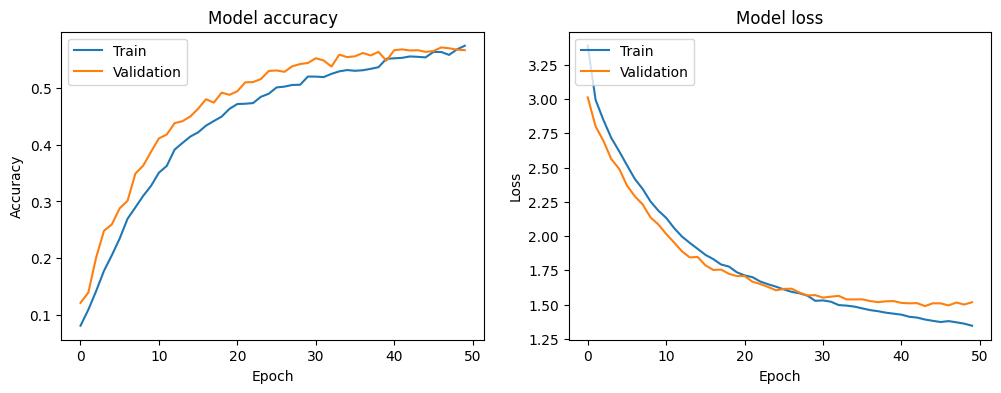

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

            A      0.812     0.542     0.650        24
            B      0.708     0.567     0.630        30
            C      0.651     0.519     0.577        54
            D      0.323     0.370     0.345        27
            E      0.811     0.588     0.682        51
            F      0.600     0.167     0.261        18
            G      0.750     0.444     0.558        27
            H      1.000     0.370     0.541        27
            I      0.745     0.556     0.636        63
            J      0.800     0.508     0.621        63
            K      0.667     0.303     0.417        33
            L      0.773     0.596     0.673        57
            M      0.667     0.381     0.485        21
            N      0.375     0.167     0.231        18
            O      0.222     0.970     0.362        66
            P      0.667     0.222     0.333        27
            Q      0.692     0.333     0.450        27
         

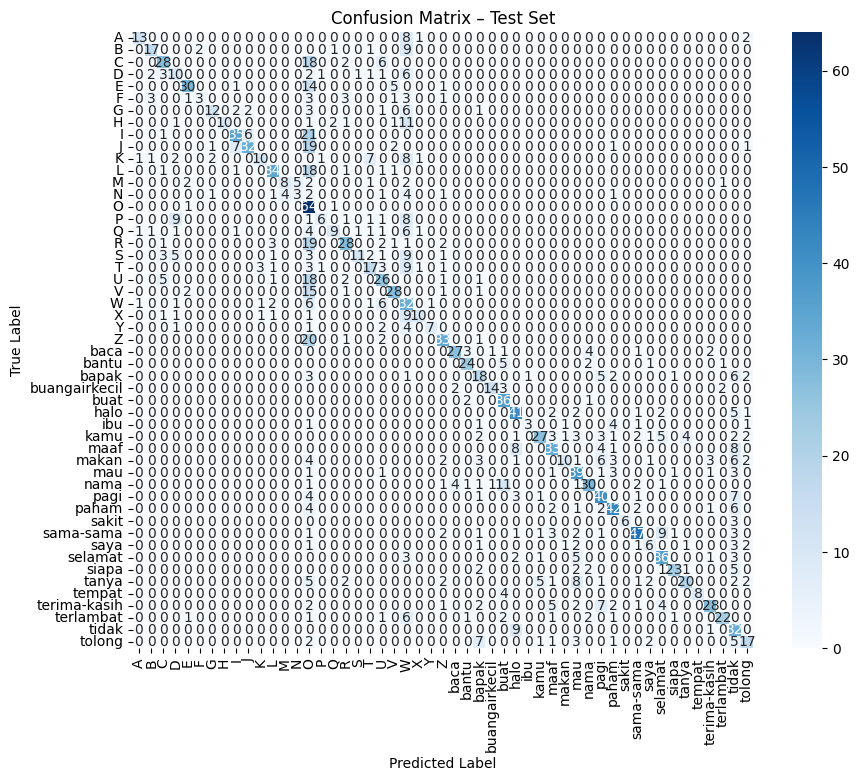

In [30]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = cnn_model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()